# Problem and data description

The goal of this project is to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans.

We are provided with a large number of small pathology images in .tif format. From the competition description we can see that a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. To further investigate the data we will perfom an EDA.

In [71]:
#import libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#get files
train_path = 'histopathologic-cancer-detection/train/'
test_path = 'histopathologic-cancer-detection/test/'
train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

In [3]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Data dimensions
We can see that training dataset contains 220025 images labeled as 0 for non-cancerous and 1 for cancerous tissue. The image shape is 96x96 pixel with 3 channels.

In [4]:
#check information and data types
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [72]:
#check image shape
img = cv2.imread(train_path + train_labels['id'][42])
print(img.shape)

(96, 96, 3)


### There are 130908 images from healthy tissues and 89117 images of cancerous tissues in the training dataset

Label Counts
0    130908
1     89117
Name: label, dtype: int64


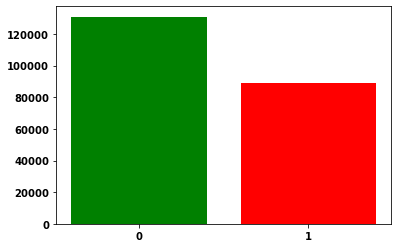

In [8]:
print(f"Label Counts\n{train_labels['label'].value_counts()}")

counts = train_labels['label'].value_counts()
plt.bar(counts.index, counts.values, color=('green', 'red'))
plt.xticks(counts.index)
plt.show()   
    


In [5]:
#since the id column has the type 'object' we can convert it to the 'string' datatype
train_labels['label'] = train_labels['label'].astype(str)

In [6]:
#to furthe simplify our code we will also add .tif suffix to the ids
train_labels['id'] = train_labels['id'] + '.tif'

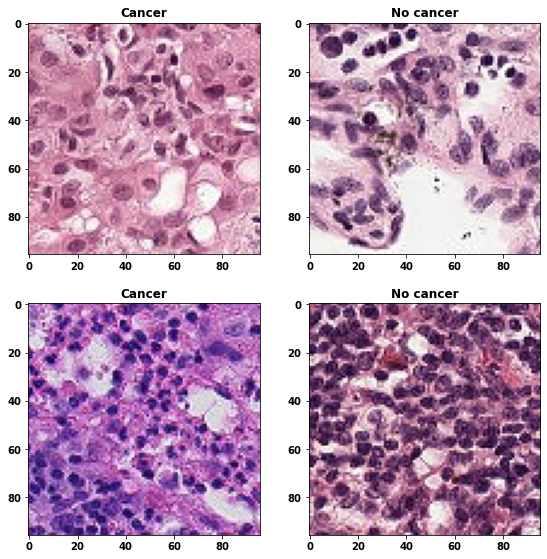

In [9]:
# visualizing some random examples from the dataset
cancer = train_labels.loc[train_labels['label'] == '1'].sample(100)
cancer.reset_index(inplace=True, drop=True)
no_cancer = train_labels.loc[train_labels['label'] == '0'].sample(100)
no_cancer.reset_index(inplace=True, drop=True)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
fig.tight_layout(pad=1.5)

for i in range(2):
    image = plt.imread(train_path + cancer.id[i])
    image2 = plt.imread(train_path + no_cancer.id[i])
    ax[i,0].imshow(image)
    ax[i,0].set_title('Cancer')
    ax[i,1].imshow(image2)
    ax[i,1].set_title('No cancer')

# Data cleaning

We can check if there are some very dark or too bright images in the dataset. Such images could slightly affect training performance so it's better to remove them.

In [10]:
#set threshold for dark/bright images
dark_th = 10 / 255
bright_th = 245 / 255
too_dark_idx = []
too_bright_idx = []

for i in range(len(train_labels)):
    img = cv2.imread(train_path + train_labels['id'][i]).reshape(-1, 3)
    if((img.max()/255) < dark_th):
        too_dark_idx.append(train_labels['id'][i])
        continue 
        
    if((img.min()/255) > bright_th):
        too_bright_idx.append(train_labels['id'][i])
        continue 

In [11]:
print(f'Too dark images:\n{", ".join(too_dark_idx)}\n\nToo bright images:\n{chr(10).join(too_bright_idx)}')

Too dark images:
9369c7278ec8bcc6c880d99194de09fc2bd4efbe.tif

Too bright images:
9071b424ec2e84deeb59b54d2450a6d0172cf701.tif
f6f1d771d14f7129a6c3ac2c220d90992c30c10b.tif
5f30d325d895d873d3e72a82ffc0101c45cba4a8.tif
54df3640d17119486e5c5f98019d2a92736feabc.tif
5a268c0241b8510465cb002c4452d63fec71028a.tif
c448cd6574108cf14514ad5bc27c0b2c97fc1a83.tif


In [73]:
to_clean = too_dark_idx + too_bright_idx

In [13]:
for i in range(len(to_clean)):
    img = cv2.imread(train_path + to_clean[i])

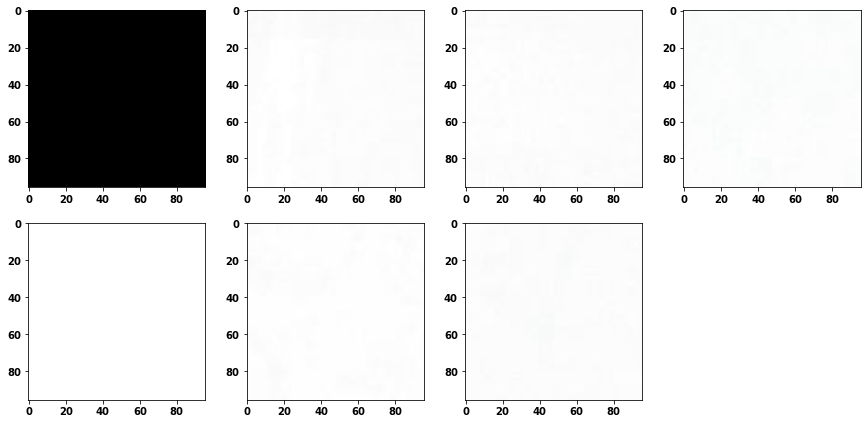

In [14]:
#visualize too dark/bright images
plt.figure(figsize=(15,15))
n = 0
for i in to_clean:
    img = cv2.imread(train_path + i)
    plt.subplot(4,4,n+1)
    plt.imshow(img)
    n += 1
plt.show()

In [15]:
#deleting images
for n in to_clean:
    idx = train_labels[train_labels['id'] == n].index
    train_labels.drop(idx, inplace=True)
    print ('Deleting image ', n)

Deleting image  9369c7278ec8bcc6c880d99194de09fc2bd4efbe.tif
Deleting image  9071b424ec2e84deeb59b54d2450a6d0172cf701.tif
Deleting image  f6f1d771d14f7129a6c3ac2c220d90992c30c10b.tif
Deleting image  5f30d325d895d873d3e72a82ffc0101c45cba4a8.tif
Deleting image  54df3640d17119486e5c5f98019d2a92736feabc.tif
Deleting image  5a268c0241b8510465cb002c4452d63fec71028a.tif
Deleting image  c448cd6574108cf14514ad5bc27c0b2c97fc1a83.tif


# Dataset generation

We will use Keras’ ImageDataGenerator to generate training, validation (and later test) datasets. The flow_from_dataframe() method takes the Pandas DataFrame and the path to a directory with images and generates batches of normalized data.

In [16]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.15)

train_generator = datagen.flow_from_dataframe(
dataframe=train_labels,
directory=train_path,
x_col='id',
y_col='label',
subset='training',
batch_size=256,
seed=42,
shuffle=True,
class_mode='binary',
target_size=(96,96))

valid_generator = datagen.flow_from_dataframe(
dataframe=train_labels,
directory=train_path,
x_col='id',
y_col='label',
subset='validation',
batch_size=256,
seed=42,
shuffle=True,
class_mode='binary',
target_size=(96,96))


Found 187016 validated image filenames belonging to 2 classes.
Found 33002 validated image filenames belonging to 2 classes.


# Model creation

For this project we will create two simple CNN models and compare their performance

## Model 1

The first model contains 3 convolutional layers each followed by maxpooling layer, flatten layer (collapses the spatial dimensions of the input into the channel dimension) and 2 dense layers, last of which is an output. We will use a sigmoid activation function on the output layer. We will also use an adaptive moment estimation (Adam) optimizer.

In [24]:
opt = keras.optimizers.Adam(learning_rate=0.01, epsilon=0.1)

In [25]:
model_1 = Sequential()
model_1.add(layers.Conv2D(16, (3, 3), input_shape=(96, 96, 3), activation='relu', padding = 'same'))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_1.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_1.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model_1.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(256, activation="relu"))
model_1.add(layers.Dense(1, activation='sigmoid'))



model_1.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', 'AUC'])

In [26]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 64)      

In [27]:
history_1 = model_1.fit(train_generator,validation_data=valid_generator,epochs=10,batch_size=256, 
                        verbose=True)

Epoch 1/10
731/731 [==============================] - 811s 1s/step - loss: 0.5049 - accuracy: 0.7501 - auc: 0.8222 - val_loss: 0.4245 - val_accuracy: 0.8117 - val_auc: 0.8832
Epoch 2/10
731/731 [==============================] - 823s 1s/step - loss: 0.4133 - accuracy: 0.8148 - auc: 0.8866 - val_loss: 0.3752 - val_accuracy: 0.8406 - val_auc: 0.9100
Epoch 3/10
731/731 [==============================] - 797s 1s/step - loss: 0.3736 - accuracy: 0.8367 - auc: 0.9091 - val_loss: 0.3508 - val_accuracy: 0.8523 - val_auc: 0.9243
Epoch 4/10
731/731 [==============================] - 786s 1s/step - loss: 0.3469 - accuracy: 0.8509 - auc: 0.9223 - val_loss: 0.3363 - val_accuracy: 0.8579 - val_auc: 0.9280
Epoch 5/10
731/731 [==============================] - 791s 1s/step - loss: 0.3276 - accuracy: 0.8603 - auc: 0.9310 - val_loss: 0.3127 - val_accuracy: 0.8680 - val_auc: 0.9383
Epoch 6/10
731/731 [==============================] - 803s 1s/step - loss: 0.3095 - accuracy: 0.8685 - auc: 0.9386 - val_loss

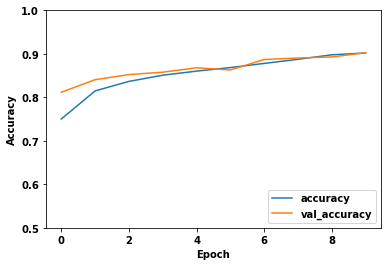

In [28]:
#plot model accuracy
plt.plot(history_1.history['accuracy'], label='accuracy')
plt.plot(history_1.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

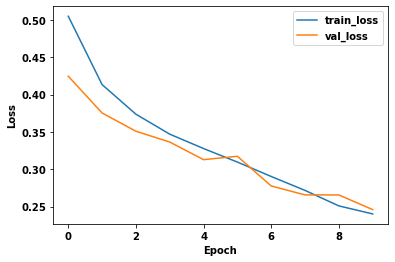

In [29]:
#plot model loss
plt.plot(history_1.history['loss'], label='train_loss')
plt.plot(history_1.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

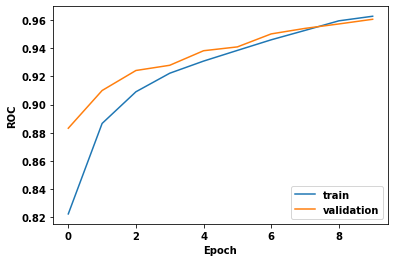

In [30]:
#plot ROC curve
plt.plot(history_1.history['auc'], label='train')
plt.plot(history_1.history['val_auc'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend(loc='lower right')

## Model 2

In the second model we will double convolutional layers and also add **dropout** layers. We will set dropout at 0.1 after Maxpooling layers and 0.25 after the Dense layer which will randonly select some weights and set them to equal 0 which regularizes the model because it is using a smaller number of weights for each training run.

In [31]:
model_2 = Sequential()
model_2.add(layers.Conv2D(32, (3, 3), input_shape=(96, 96, 3), padding = 'same', activation='relu'))
model_2.add(layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Dropout(0.1))

model_2.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Dropout(0.1))

model_2.add(layers.Conv2D(128, (3, 3), padding = 'same', activation='relu'))
model_2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_2.add(layers.Dropout(0.1))

model_2.add(layers.Flatten())
model_2.add(layers.Dense(512, activation="relu"))
model_2.add(layers.Dropout(0.25))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', 'AUC'])

In [32]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                      

In [33]:
history_2 = model_2.fit(train_generator,validation_data=valid_generator,epochs=10,batch_size=256, 
                        verbose=True)

Epoch 1/10
731/731 [==============================] - 2813s 4s/step - loss: 0.4903 - accuracy: 0.7633 - auc: 0.8343 - val_loss: 0.4695 - val_accuracy: 0.7883 - val_auc: 0.8822
Epoch 2/10
731/731 [==============================] - 2852s 4s/step - loss: 0.3941 - accuracy: 0.8297 - auc: 0.8970 - val_loss: 0.3707 - val_accuracy: 0.8462 - val_auc: 0.9180
Epoch 3/10
731/731 [==============================] - 2829s 4s/step - loss: 0.3549 - accuracy: 0.8487 - auc: 0.9182 - val_loss: 0.3362 - val_accuracy: 0.8602 - val_auc: 0.9288
Epoch 4/10
731/731 [==============================] - 2826s 4s/step - loss: 0.3294 - accuracy: 0.8599 - auc: 0.9304 - val_loss: 0.3218 - val_accuracy: 0.8643 - val_auc: 0.9402
Epoch 5/10
731/731 [==============================] - 2845s 4s/step - loss: 0.3130 - accuracy: 0.8673 - auc: 0.9374 - val_loss: 0.2940 - val_accuracy: 0.8753 - val_auc: 0.9465
Epoch 6/10
731/731 [==============================] - 2832s 4s/step - loss: 0.2972 - accuracy: 0.8747 - auc: 0.9435 - va

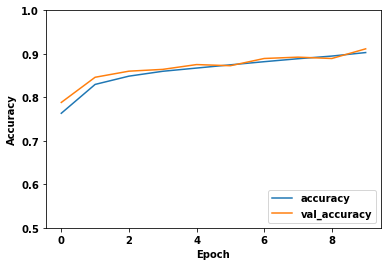

In [34]:
plt.plot(history_2.history['accuracy'], label='accuracy')
plt.plot(history_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

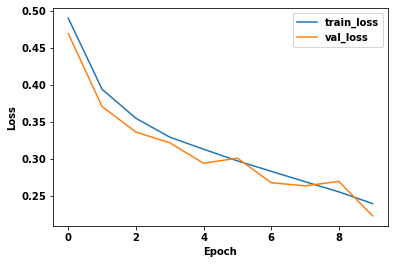

In [35]:
plt.plot(history_2.history['loss'], label='train_loss')
plt.plot(history_2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

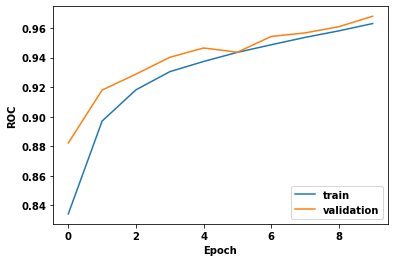

In [36]:
plt.plot(history_2.history['auc'], label='train')
plt.plot(history_2.history['val_auc'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend(loc='lower right')

# Make predictions and create submissions files

In [37]:
test_labels = pd.read_csv('histopathologic-cancer-detection/sample_submission.csv')

In [38]:
test_labels['label'] = test_labels['label'].astype('str')

In [39]:
test_labels['id'] = test_labels['id'] + '.tif'

In [40]:
test_labels.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,0


In [41]:
datagen_test = ImageDataGenerator(rescale=1./255.)

In [68]:
test_generator = datagen_test.flow_from_dataframe(
            dataframe=test_labels,
            directory=test_path,
            x_col='id',
            y_col='label',
            batch_size=256,
            seed=42,
            shuffle=False,
            target_size=(96,96))

Found 57458 validated image filenames belonging to 1 classes.


In [69]:
predictions_1 = model_1.predict(test_generator, verbose=True)
predictions_1 = np.where(predictions_1<0.5, 0, 1)
predictions_1 = np.transpose(predictions_1)[0]
submission = pd.DataFrame()
submission['id'] = test_labels['id'].apply(lambda x: x.split('.')[0])
submission['label'] = list(predictions_1)
submission.to_csv('submission_model_1.csv', index=False)

225/225 [==============================] - 127s 565ms/step


In [70]:
predictions_2 = model_2.predict(test_generator, verbose=True)
predictions_2 = np.where(predictions_2<0.5, 0, 1)
predictions_2 = np.transpose(predictions_2)[0]
submission = pd.DataFrame()
submission['id'] = test_labels['id'].apply(lambda x: x.split('.')[0])
submission['label'] = list(predictions_2)
submission.to_csv('submission_model_2.csv', index=False)

225/225 [==============================] - 60s 265ms/step


# Conclusion

From the above plots and diagrams we can evaluate how well models performed with the training (and validation) sets. We can see that the second model with increased number of layers and added regularization performed slightly better than the first one. 

To further improve our results we can also perform image augmentation. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

It also makes sense to increase number of epochs and decrease learning rate, however it will also increase our training time.

### Link to github